This tutorial reproduces the results of Tutorial 8 on spinw.org. This tutorial first uses the supercell method and then the single Q method to reproduce the same results.

Get Packages and required files.

In [62]:
using Sunny, Revise,LinearAlgebra,CairoMakie,GLMakie
using Optim, Optimization, OptimizationOptimJL
includet("DispersionAndIntensitiesDipoleSingleQ.jl")
includet("SWTSingleQcalculations.jl")


Define the lattice. Set up the lattice, the position of magnetic atoms, the symmetry inequivalent postions and the spin. Space group is P-3 or 147. When position of one atom is specified, Sunny uses the space group symmetry to generate all other atoms in the unit cell. The supercell is (3,3,1).

In [63]:
a=6.0
b=6.0
c=40.0

latvecs = lattice_vectors(a, b, c, 90, 90, 120)
positions=[[1/2, 0, 0]]
Cr = Crystal(latvecs,positions,147)
view_crystal(Cr)
print_symmetry_table(Cr,8)
sys=System(Cr, (3,3,1),[SpinInfo(1,S=1,g=2)], :dipole, seed=0)

Atom 1
Position [1/2, 0, 0], multiplicity 3
Allowed g-tensor: [  A F+I E-H
                   F-I   B D+G
                   E+H D-G   C]
Allowed anisotropy in Stevens operators:
    c₁*𝒪[2,-2] + c₂*𝒪[2,-1] + c₃*𝒪[2,0] + c₄*𝒪[2,1] + c₅*𝒪[2,2] +
    c₆*𝒪[4,-4] + c₇*𝒪[4,-3] + c₈*𝒪[4,-2] + c₉*𝒪[4,-1] + c₁₀*𝒪[4,0] + c₁₁*𝒪[4,1] + c₁₂*𝒪[4,2] + c₁₃*𝒪[4,3] + c₁₄*𝒪[4,4] +
    c₁₅*𝒪[6,-6] + c₁₆*𝒪[6,-5] + c₁₇*𝒪[6,-4] + c₁₈*𝒪[6,-3] + c₁₉*𝒪[6,-2] + c₂₀*𝒪[6,-1] + c₂₁*𝒪[6,0] + c₂₂*𝒪[6,1] + c₂₃*𝒪[6,2] + c₂₄*𝒪[6,3] + c₂₅*𝒪[6,4] + c₂₆*𝒪[6,5] + c₂₇*𝒪[6,6]

Bond(2, 3, [0, 0, 0])
Distance 3, coordination 4
Connects [0, 1/2, 0] to [1/2, 1/2, 0]
Allowed exchange matrix: [  A F+I E-H
                          F-I   B D+G
                          E+H D-G   C]
Allowed DM vector: [G H I]

Bond(2, 1, [0, 0, 0])
Distance 5.1961524227066, coordination 4
Connects [0, 1/2, 0] to [1/2, 0, 0]
Allowed exchange matrix: [  A F+I E-H
                          F-I   B D+G
                          E+H D-G   C]
Allowed DM v

System [Dipole mode]
Lattice (3×3×1)×3
Energy per site 0


Set up the exchanges. Now, since it is an incommensurate case, instead of randomizing the spin, orientations of spins on each sublattice needs to be specified using "set_spiral_order_on_sublattice!". An axis about which the spins would rotate also needs to be specified. Also since the orientation was determined manually, further minimization of energy is not needed.

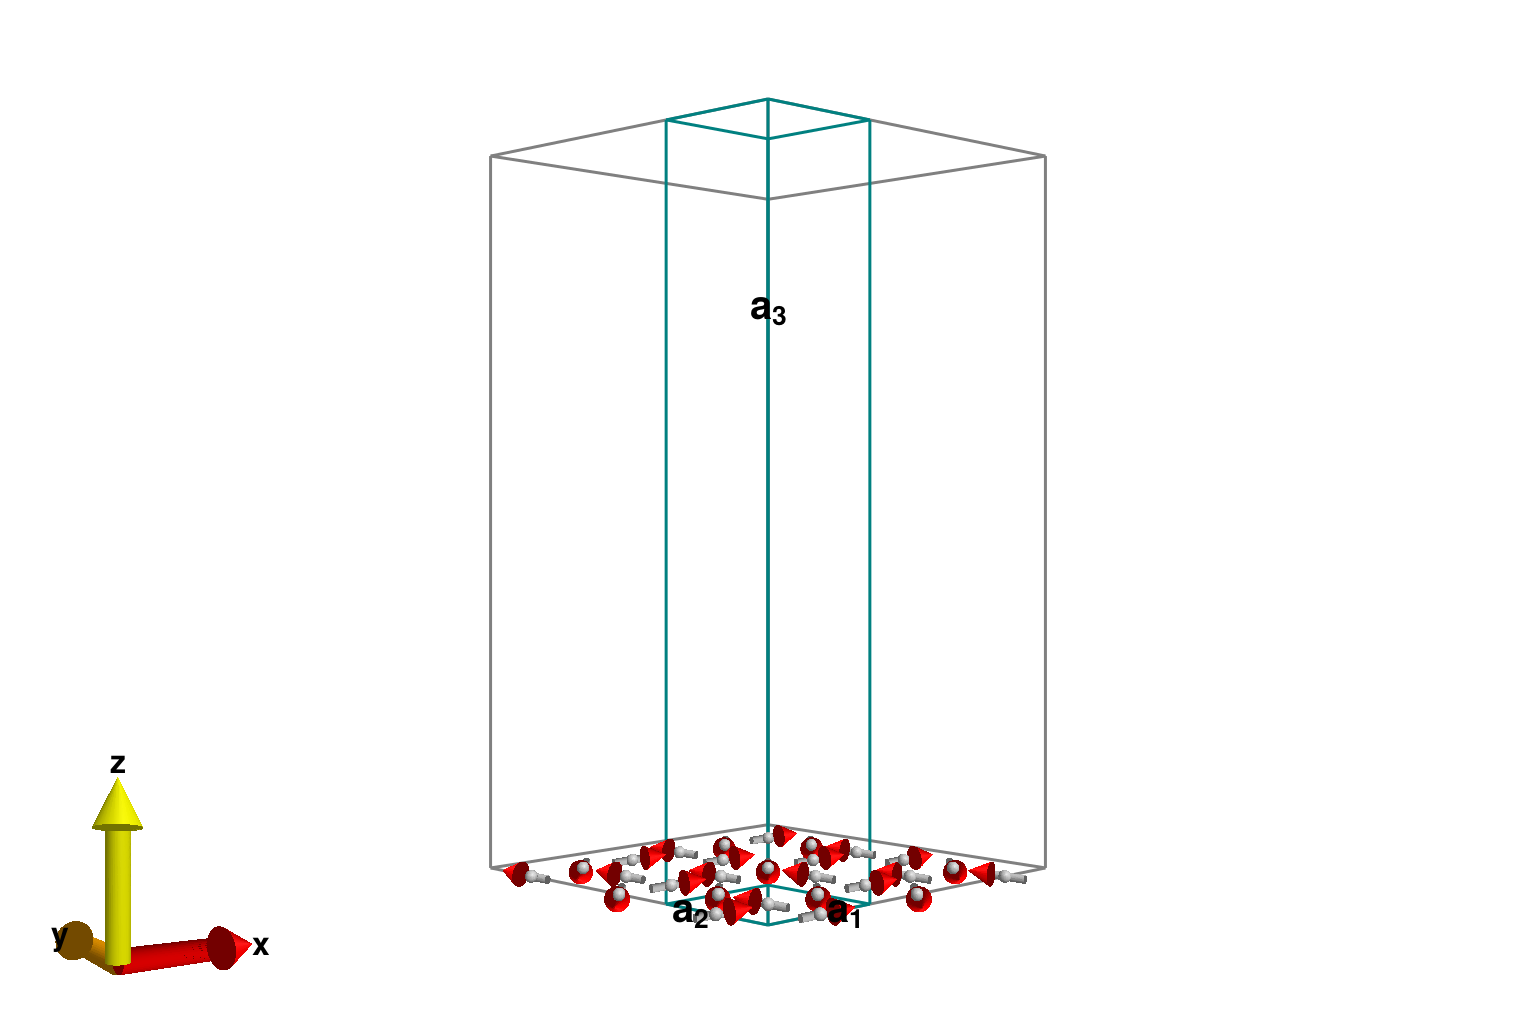

In [64]:
J1=1.0
set_exchange!(sys,J1,Bond(2, 3, [0, 0, 0]))
q = -[1/3, 1/3, 0]
axis = [0,0,1]
set_spiral_order_on_sublattice!(sys, 1; q, axis, S0=[cos(0),sin(0),0])
set_spiral_order_on_sublattice!(sys, 2; q, axis, S0=[cos(0),sin(0),0])
set_spiral_order_on_sublattice!(sys, 3; q, axis, S0=[cos(2π/3),sin(2π/3),0])
plot_spins(sys)


Create the LSWT object and set up a path. Obtain the dispersion and intensity bands.

In [65]:
q_points = [[-1/2,0,0], [0,0,0], [1/2,1/2,0]]
density = 50
path, xticks = reciprocal_space_path(Cr, q_points, density);
swt=SpinWaveTheory(sys)
formula = intensity_formula(swt, :perp; kernel=delta_function_kernel)
disp, intensity = intensities_bands(swt, path, formula);

Plot the dispersion and convoluted spectra.

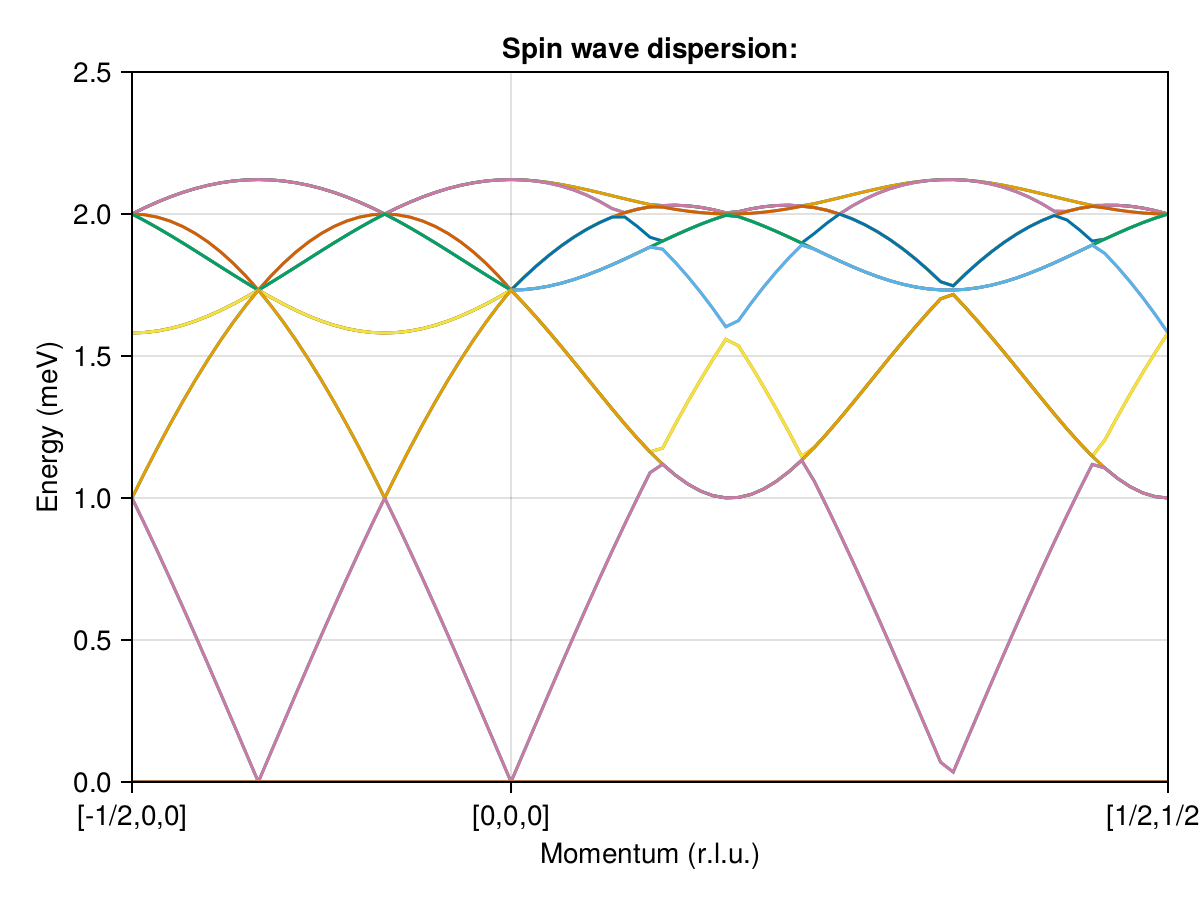

In [66]:
CairoMakie.activate!()
fig = Figure()
ax = Axis(fig[1,1]; xlabel="Momentum (r.l.u.)", ylabel="Energy (meV)",title="Spin wave dispersion:", xticks)
ylims!(ax, 0.0, 2.5)
xlims!(ax, 1, size(disp, 1))
colorrange = extrema(intensity)
for i in axes(disp)[2]
    lines!(ax, 1:length(disp[:,i]), disp[:,i]; color="black", colorrange)
end
fig

In [74]:
γ = 0.02 
broadened_formula = intensity_formula(swt, :perp; kernel=lorentzian(γ))
energies = collect(0:0.01:10)  
is = intensities_broadened(swt, path, energies, broadened_formula);
fig = Figure()
ax = Axis(fig[1,1]; xlabel="Momentum (r.l.u.)", ylabel="Energy (meV)",title="Convoluted spectra:", xticks)
ylims!(ax, 0.0, 3.0)
pl=heatmap!(ax, 1:size(is, 1), energies, is,colorrange=(0,5))
pl.colormap = Reverse(:Spectral)
fig

ErrorException: Instability at wavevector q = [-0.5, 0.0, 0.0]

The following code will use the single Q method to reproduce the results.

The crystal has already been built, so there is no need to make it again. However, the system needs to be created again with a supercell size (1,1,1) to ease calculations.

In [68]:
sys = System(Cr,(1,1,1),[SpinInfo(1,S=1,g=2)], :dipole,seed =0)

System [Dipole mode]
Lattice (1×1×1)×3
Energy per site 0


Set up the exchanges. Since the single Q method is being used, an axis of rotation needs to be specified.

In [69]:
bond1 = Bond(2,3,[0,0,0])
J1 = 1.
set_exchange!(sys,[J1 0. 0.;0 J1 0;0 0 J1],bond1)
# Axis of rotation, n = [0.0,0.0,1], along c -direction.  
# We can also check whether the interaction of system is invariant under axis of rotation using check_rotational_symmetry function.
n = [0.,0,1]
Sunny.check_rotational_symmetry(sys; n, θ=0.01)

Randomize the spins. A range of parameters needs to provided along with inital guesses for these parameters. "optimagstr" is used to obtained (kx,ky,kz) the propagation vector.

In [70]:
randomize_spins!(sys)
#       Phi1   Phi2  Phi3  k_x  k_y   k_z
xmin = [-1e-6 -1e-6 -1e-6 -1e-6 -1e-6 -1e-6] # Minimum value of x
xmax = [2π 2π 2π 1 1 1e-6]  # Maximum value of x
x0 = [0.2 0.2 0.2 0.3 0.3 0.0]  # Initial value of x
k = optimagstr(x ->gm_planar!(sys,n,x),xmin,xmax,x0)

Ground state Energy(meV) = -3.0


3-element Vector{Float64}:
  0.3333333336470808
  0.33333333370361545
 -9.24951520917637e-12

Set up the LSWT object along a path to obtain the dispersion bands. Note that different functions have been used to obtain the dispersion and intensity bands in the sinle Q method as compared to supercell method.

In [71]:
qs = [[-0.5,0,0.],[0.0,0.,0],[0.5,0.5,0]]
density = 250
path, xticks = reciprocal_space_path(Cr, qs, density)
swt = SpinWaveTheory(sys)
formula = intensity_formula_SingleQ(swt,k,n, :perp; kernel=delta_function_kernel)
disp, intensity = intensities_bands_SingleQ(swt, path, formula);

norm(H-H')= 1.6801853353415797


String: "H is not hermitian!"

Plot the dispersion and convoluted spectra. Note that in the convoluted spectra, the zero mode has been removed for a better result.

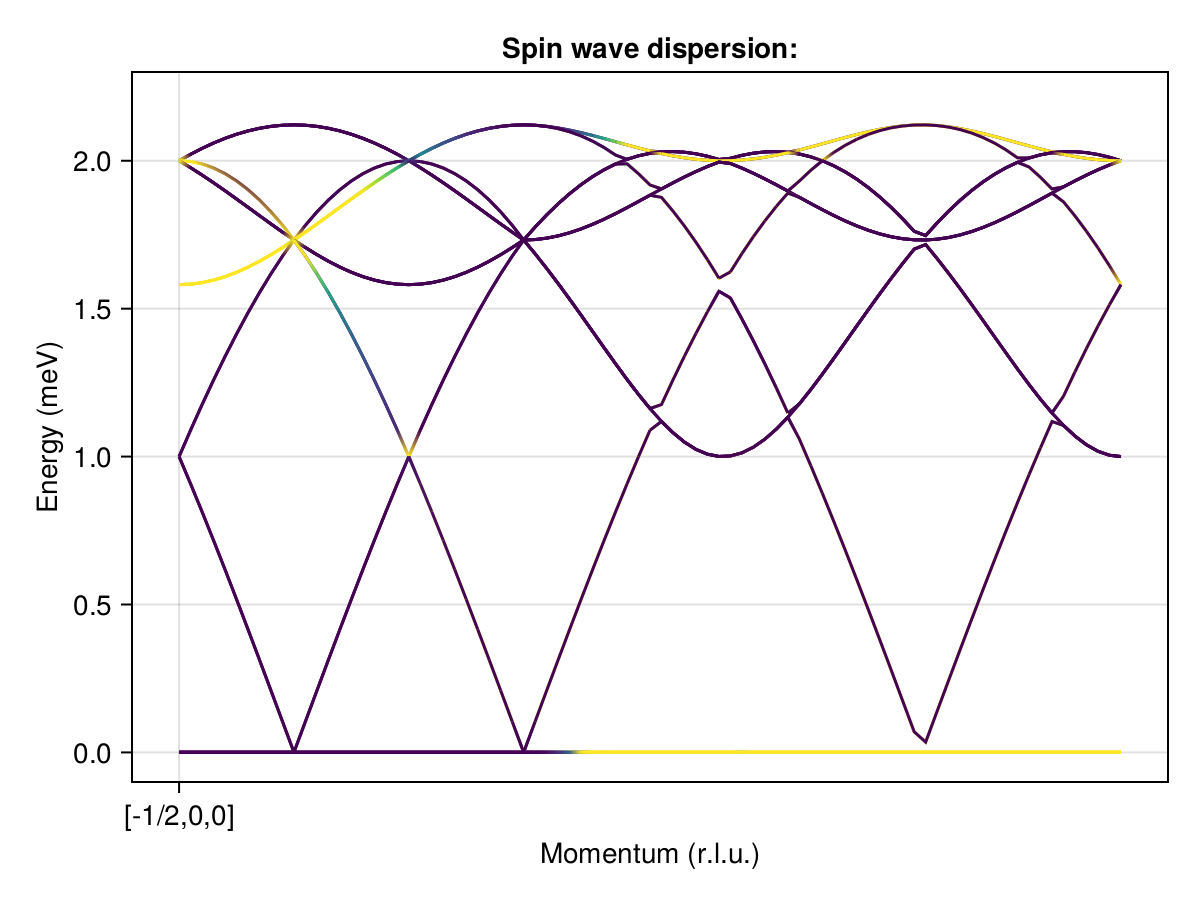

In [72]:
CairoMakie.activate!()
fig = Figure()
ax = Axis(fig[1,1]; xlabel="Momentum (r.l.u.)", ylabel="Energy (meV)", xticks,title="Spin wave dispersion:")
ylims!(ax, -1e-1, 2.3)
for i in axes(disp, 2)
    lines!(ax, 1:length(disp[:,i]), disp[:,i]; color=intensity[:,i], colorrange=(0,1e-2))
end
fig

There are is a zero mode that is very intense. It is removed from the plot to make it better. It is removed using "sum(is[:,:,:,:])". In the third column, instead of "1:3" we write "1:2" thereby removing the 3rd mode which is actually the zero mode. 

In [73]:
γ = 0.02 # width in meV
broadened_formula = intensity_formula_SingleQ(swt,k,n, :perp; kernel=lorentzian(γ),formfactors=nothing)
energies = collect(0:0.005:3)  # 0 < ω < 10 (meV).
is = intensities_broadened_SingleQ(swt, path, energies, broadened_formula);

begin
    CairoMakie.activate!()
    fig = Figure() 
    ax = Axis(fig[1,1];title="SingleQ Convoluted spectra", xlabel="Momentum (r.l.u.)", ylabel="Energy (meV)", xticks)
    pl = heatmap!(ax,1:size(is, 1),energies,dropdims(sum(is[:,:,1:2,1:3],dims=[3,4]),dims=(3,4)))
    pl.colormap = Reverse(:Spectral)
    pl.colorrange = (0,1.5)
    fig
end


###explain how to remove zero mode

norm(H-H')= 1.6801853353415797


String: "H is not hermitian!"